In [58]:
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')



In [59]:
cars_path = 'C:/Users/muham/OneDrive/Masaüstü/FIZ-437E/HAM DATA/cars-gray/'
flowers_path = 'C:/Users/muham/OneDrive/Masaüstü/FIZ-437E/HAM DATA/flower-gray/'

cars = os.listdir(cars_path)
flowers = os.listdir(flowers_path)

In [60]:
train_size = 0.9

In [61]:
def img2vector(path, image_name):
    image = Image.open(os.path.join(path, image_name))
    vector = np.array(image)
    vector = vector.flatten()
    return vector

In [62]:
car_vectors = np.zeros((len(cars), 2500))
for i in range(0, len(cars)):
    car_vectors[i] = img2vector(cars_path, cars[i])

In [63]:
flowers_vectors = np.zeros((len(flowers), 2500))
for i in range(0, len(flowers)):
    flowers_vectors[i] = img2vector(flowers_path, flowers[i])

In [64]:
car = pd.DataFrame(car_vectors)
flowers_df = pd.DataFrame(flowers_vectors)

car['label'] = 1
flowers_df['label'] = -1

car_train = car.sample(frac=train_size, random_state=200)
car_test = car.drop(car_train.index)

flowers_train = flowers_df.sample(frac=train_size, random_state=200)
flowers_test = flowers_df.drop(flowers_train.index)

train_df = pd.concat([car_train, flowers_train])
test_df = pd.concat([car_test, flowers_test])

In [65]:
train_x = train_df.drop('label', axis=1)
train_y = train_df['label']

test_x = test_df.drop('label', axis=1)
test_y = test_df['label']

In [66]:
#logistic regression from scratch
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(theta, x, y):
    m = len(y)
    h = sigmoid(x @ theta)
    epsilon = 1e-5
    cost = (-1 / m) * (np.log(h + epsilon).T @ y + np.log(1 - h + epsilon).T @ (1 - y))
    return cost

def gradient(theta, x, y):
    m = len(y)
    return (1 / m) * x.T @ (sigmoid(x @ theta) - y)

def fit(x, y, theta):
    cost_history = []
    for i in range(1000):
        theta = theta - 0.001 * gradient(theta, x, y)
        cost_history.append(cost_function(theta, x, y))
    return theta, cost_history

def predict(x, theta):
    return np.round(sigmoid(x @ theta))

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

In [67]:
#run logistic regression
x = train_x.to_numpy()
y = train_y.to_numpy()
theta = np.zeros(x.shape[1])
theta, cost_history = fit(x, y, theta)
y_pred = predict(x, theta)
print('Train accuracy: ', accuracy(y, y_pred))

x_test = test_x.to_numpy()
y_test = test_y.to_numpy()
y_pred_test = predict(x_test, theta)
print('Test accuracy: ', accuracy(y_test, y_pred_test))

Train accuracy:  0.10888888888888888
Test accuracy:  0.12


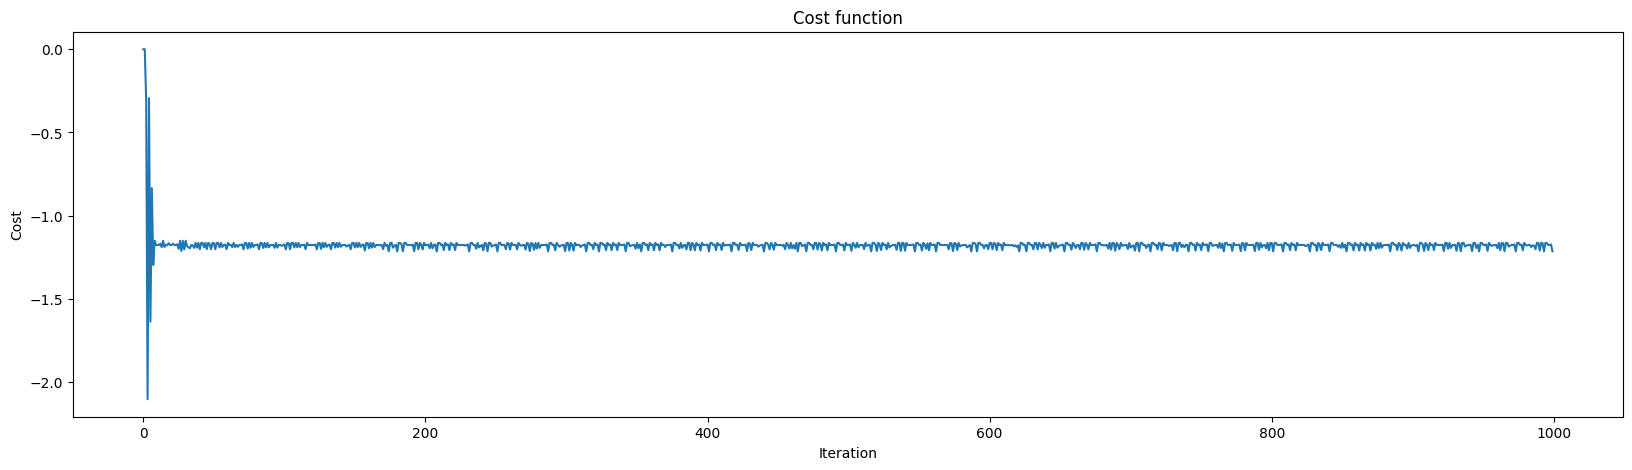

In [68]:
#loss function plot wider
plt.figure(figsize=(20, 5))
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost function')
plt.show()

Train accuracy:  0.5
Test accuracy:  0.5


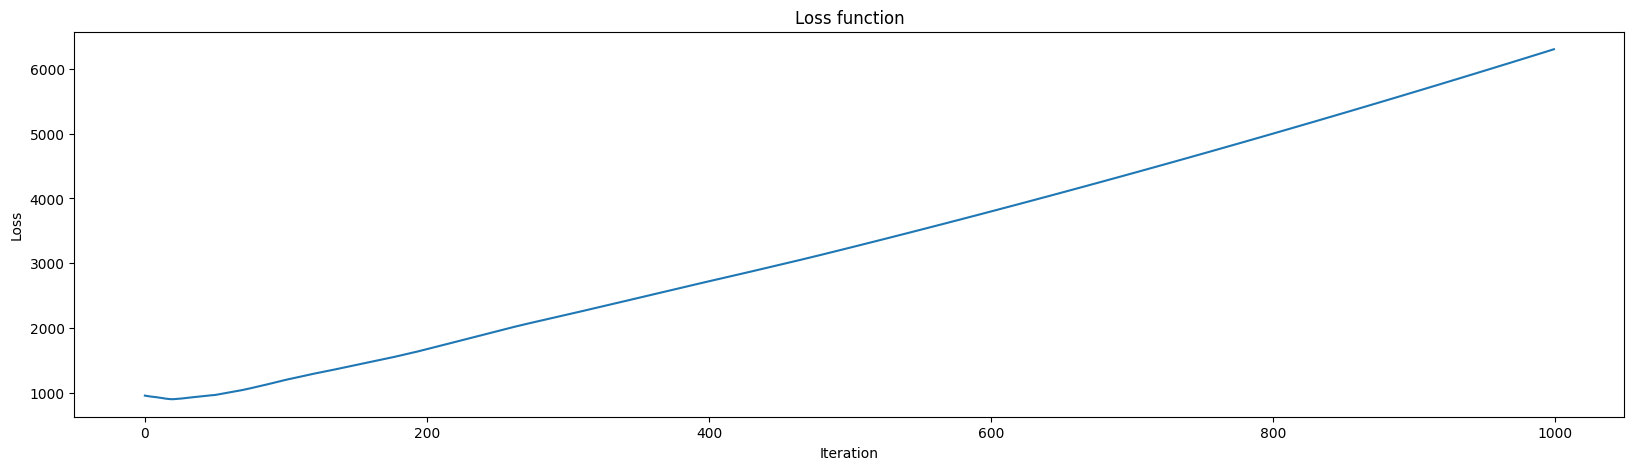

In [69]:
def svm_loss(w, x, y, reg):
    delta = 1.0
    m = x.shape[0]
    scores = x.dot(w)
    margins = np.maximum(0, scores - scores[y] + delta)
    margins[y] = 0
    loss = np.sum(margins) / m
    loss += 0.5 * reg * np.sum(w * w)
    return loss

def svm_loss_gradient(w, x, y, reg):
    delta = 1.0
    m = x.shape[0]
    dw = np.zeros(w.shape)
    scores = x.dot(w)
    margins = np.maximum(0, scores - scores[y] + delta)
    margins[y] = 0
    margins[margins > 0] = 1
    margins[y] = -np.sum(margins)
    dw = x.T.dot(margins) / m + reg * w
    return dw

def svm_fit(x, y, w, reg):
    loss_history = []
    for i in range(1000):
        w = w - 0.001 * svm_loss_gradient(w, x, y, reg)
        loss_history.append(svm_loss(w, x, y, reg))
    return w, loss_history

#run svm
x = train_x.to_numpy()
y = train_y.to_numpy()
w = np.zeros(x.shape[1])
w, loss_history = svm_fit(x, y, w, 0.1)
print('Train accuracy: ', accuracy(y, np.sign(x @ w)))

x_test = test_x.to_numpy()
y_test = test_y.to_numpy()
print('Test accuracy: ', accuracy(y_test, np.sign(x_test @ w)))

plt.figure(figsize=(20, 5))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss function')
plt.show()



Train accuracy:  0.8
Test accuracy:  0.8


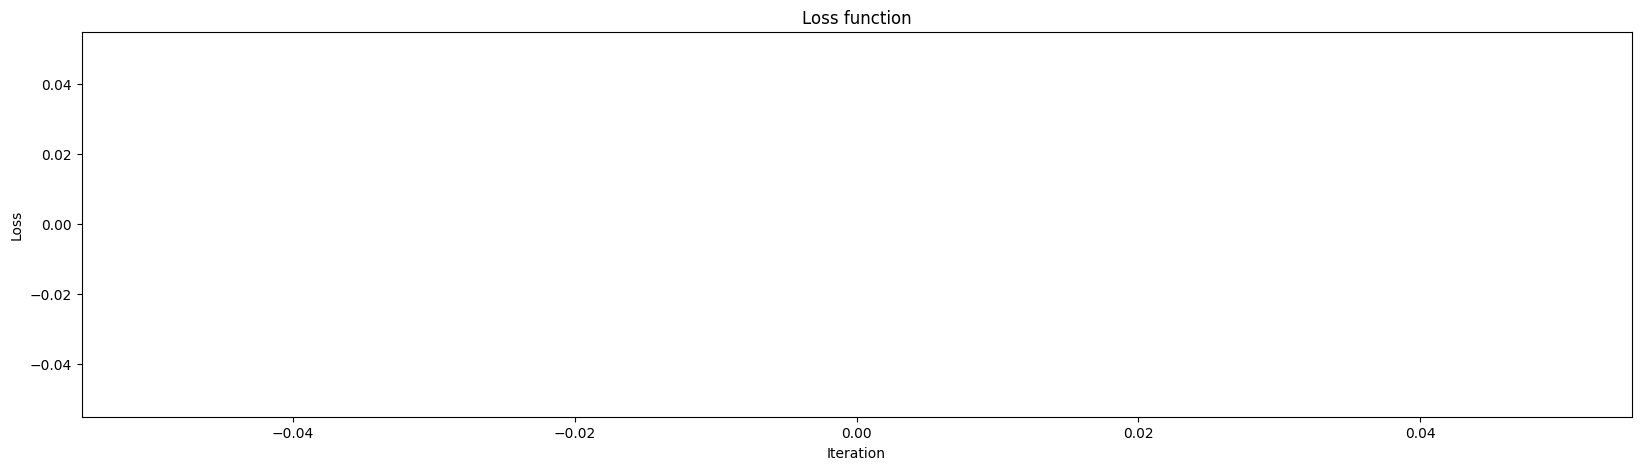

In [70]:

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_pred):
    n_samples = y.shape[0]
    res = y * np.log(y_pred)
    return -np.sum(res) / n_samples

def forward_propagation(x, w1, b1, w2, b2, w3, b3):
    z1 = x @ w1 + b1
    a1 = relu(z1)
    z2 = a1 @ w2 + b2
    a2 = relu(z2)
    z3 = a2 @ w3 + b3
    a3 = softmax(z3)
    return z1, a1, z2, a2, z3, a3

def back_propagation(x, y, w1, b1, w2, b2, w3, b3, z1, a1, z2, a2, z3, a3):
    n_samples = x.shape[0]
    dz3 = a3 - y
    dw3 = a2.T @ dz3
    db3 = np.sum(dz3, axis=0, keepdims=True)
    dz2 = (dz3 @ w3.T) * relu_derivative(a2)
    dw2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)
    dz1 = (dz2 @ w2.T) * relu_derivative(a1)
    dw1 = x.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)
    return dw1, db1, dw2, db2, dw3, db3

def nn_fit(x, y, w1, b1, w2, b2, w3, b3, learning_rate, epochs):
    loss_history = []
    for i in range(epochs):
        z1, a1, z2, a2, z3, a3 = forward_propagation(x, w1, b1, w2, b2, w3, b3)
        loss = cross_entropy(y, a3)
        loss_history.append(loss)
        dw1, db1, dw2, db2, dw3, db3 = back_propagation(x, y, w1, b1, w2, b2, w3, b3, z1, a1, z2, a2, z3, a3)
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2
        w3 -= learning_rate * dw3
        b3 -= learning_rate * db3
    return w1, b1, w2, b2, w3, b3, loss_history

def nn_predict(x, w1, b1, w2, b2, w3, b3):
    _, _, _, _, _, y_pred = forward_propagation(x, w1, b1, w2, b2, w3, b3)
    return np.argmax(y_pred, axis=1)

#run nn
x = train_x.to_numpy()
y = train_y.to_numpy()
y = np.eye(10)[y]
w1 = np.random.randn(x.shape[1], 100)
b1 = np.zeros((1, 100))
w2 = np.random.randn(100, 50)
b2 = np.zeros((1, 50))
w3 = np.random.randn(50, 10)
b3 = np.zeros((1, 10))
w1, b1, w2, b2, w3, b3, loss_history = nn_fit(x, y, w1, b1, w2, b2, w3, b3, 0.001, 1000)
print('Train accuracy: ', accuracy(y, np.eye(10)[nn_predict(x, w1, b1, w2, b2, w3, b3)]))

x_test = test_x.to_numpy()
y_test = test_y.to_numpy()
y_test = np.eye(10)[y_test]
print('Test accuracy: ', accuracy(y_test, np.eye(10)[nn_predict(x_test, w1, b1, w2, b2, w3, b3)]))

plt.figure(figsize=(20, 5))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss function')
plt.show()
